# Draft of H3 evaluation
grid-cell wise comparison of metrics
* `base`: the ground truth (manually simplified)
* `comp`: the method to compare (for now, as example: the parenx/voronoi simplification)

In [1]:
%load_ext watermark
%watermark

Last updated: 2024-06-16T22:22:37.587340-04:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import pathlib

import matplotlib.pyplot as plt
import momepy as mm
import numpy as np

from core import stats, utils, viz

%watermark -w
%watermark -iv

Watermark: 2.4.3

numpy     : 1.26.4
matplotlib: 3.8.4
core      : 0.1.dev103+gc27d2d8
momepy    : 0.7.1.dev59+ge6b0abf



settings

In [3]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

read in metadata for this FUA

In [4]:
meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

read in original OSM data, and base (manual) and comp (automated method) datasets

In [5]:
# read in orig OSM data
orig = utils.read_original(fua)

# read in base case (manual simp)
base = utils.read_manual(fua, orig.crs)

# which file to compare with?
comp = utils.read_parenx(fua, "voronoi", orig.crs)

In [6]:
# get graphs & node/edge gdfs for both data sets
base_graph = mm.gdf_to_nx(base, length="length", integer_labels=True)
comp_graph = mm.gdf_to_nx(comp, length="length", integer_labels=True)
nodes_base, edges_base = mm.nx_to_gdf(base_graph)
nodes_comp, edges_comp = mm.nx_to_gdf(comp_graph)

# add node degree to nodes df
nodes_base = stats.add_node_degree(nodes_base, base_graph)
nodes_comp = stats.add_node_degree(nodes_comp, comp_graph)

# Making h3 grid for this FUA

In [7]:
grid = utils.make_grid(fua, res, orig.crs)
grid

,geometry,hex_id
0,"POLYGON ((303013.891 -4079702.838, 302921.300 ...",89bb5000017ffff
1,"POLYGON ((302978.815 -4080433.664, 302886.222 ...",89bb5000083ffff
2,"POLYGON ((302683.497 -4080235.650, 302590.902 ...",89bb5000087ffff
3,"POLYGON ((303291.661 -4080266.265, 303199.071 ...",89bb500008bffff
4,"POLYGON ((302996.352 -4080068.251, 302903.761 ...",89bb500008fffff
...,...,...
1606,"POLYGON ((309748.648 -4091759.376, 309656.109 ...",89bb501adcfffff
1607,"POLYGON ((309713.636 -4092489.965, 309621.096 ...",89bb501add3ffff
1608,"POLYGON ((309418.508 -4092292.206, 309325.966 ...",89bb501add7ffff
1609,"POLYGON ((310026.261 -4092322.428, 309933.724 ...",89bb501addbffff


In [8]:
assert grid.crs == base.crs
assert grid.crs == comp.crs

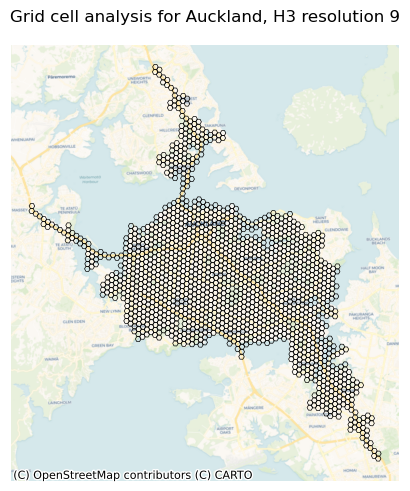

In [9]:
viz.h3_hex.plot_aoi(grid, city, res)

# Cell-wise evaluation

For evaluation: add gridcell-wise analysis of metrics:
* `edge_count`: computes total bumber of edges in a cell (after `clip`ping) 
* `edge_length`: computes total length of edges in a cell
* `node_count`: number of nodes in cell
* `degree_distr`: node degree distribution in cell 
* `avg_degree`: average node degree in cell
* displacement
* feature matching

For use cases: 
* code to zoom in to separate gridcells for use case checking

In [10]:
# add columns with geom stats and node stats

base_name = "manual"
comp_name = "parenx-voronoi"

for name, edge_gdf, node_gdf in zip(
    [base_name, comp_name], [base, comp], [nodes_base, nodes_comp], strict=True
):
    grid[[f"edge_count_{name}", f"edge_length_{name}"]] = grid.apply(
        lambda x: stats.get_edge_stats(edge_gdf, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )
    grid[[f"node_count_{name}", f"node_degrees_{name}", f"avg_degree_{name}"]] = (
        grid.apply(
            lambda x: stats.get_node_stats(node_gdf, x.geometry),  # noqa: B023
            axis=1,
            result_type="expand",
        )
    )

In [11]:
# add ratio columns
for var in ["edge_count", "edge_length", "node_count", "avg_degree"]:
    grid[f"{var}_ratio"] = grid[f"{var}_{comp_name}"] / grid[f"{var}_{base_name}"]

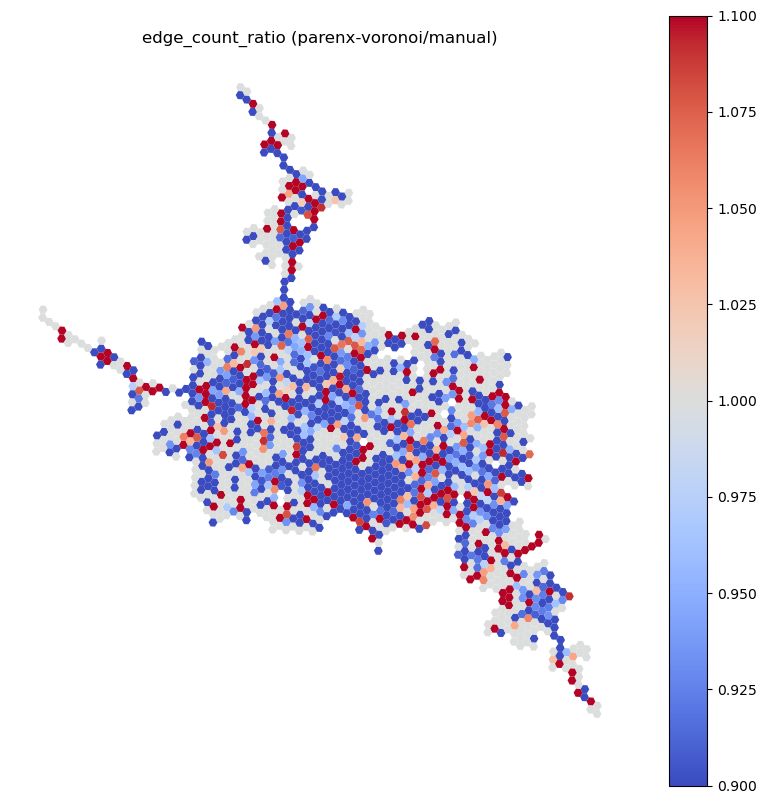

In [12]:
viz.h3_hex.plot_analysis(grid, "edge_count_ratio", info=f"({comp_name}/{base_name})")

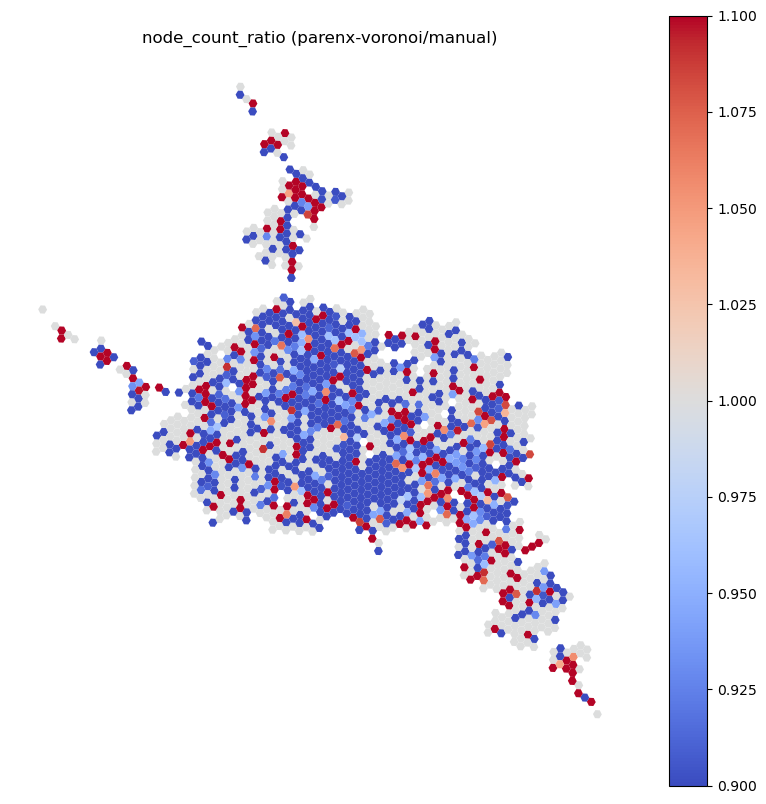

In [13]:
viz.h3_hex.plot_analysis(grid, "node_count_ratio", info=f"({comp_name}/{base_name})")

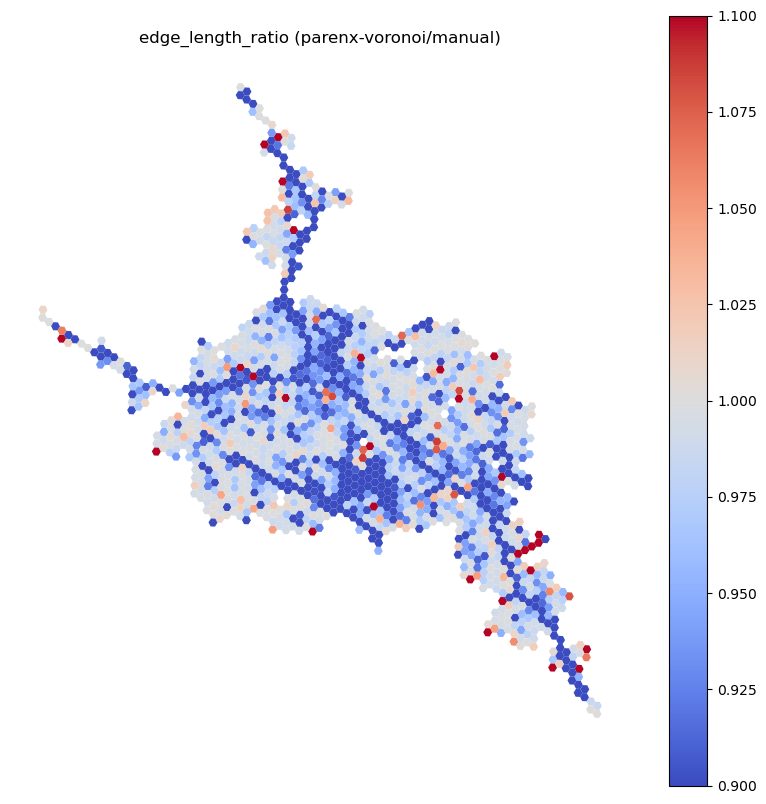

In [14]:
viz.h3_hex.plot_analysis(grid, "edge_length_ratio", info=f"({comp_name}/{base_name})")

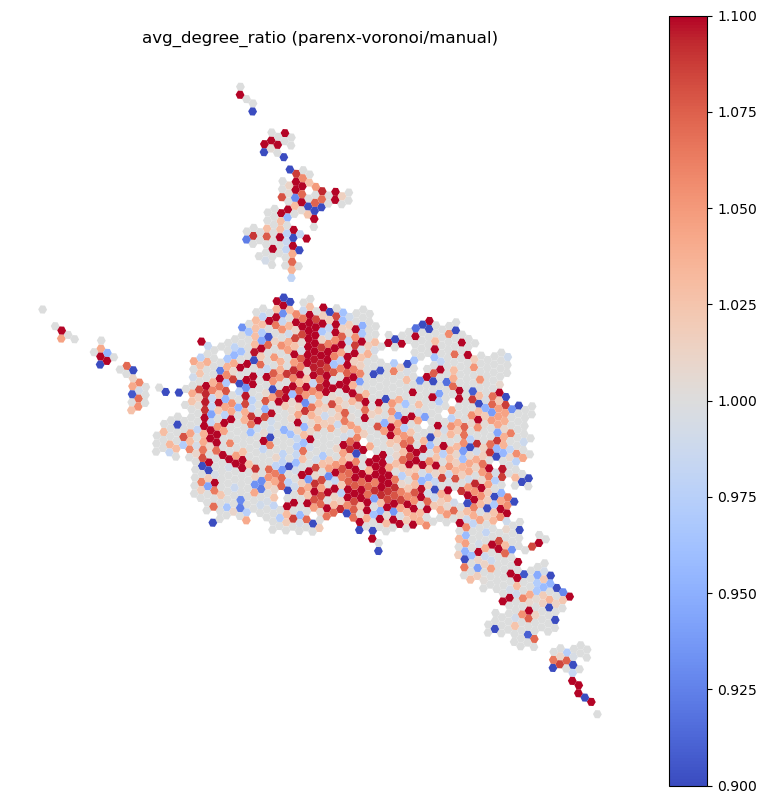

In [15]:
viz.h3_hex.plot_analysis(grid, "avg_degree_ratio", info=f"({comp_name}/{base_name})")

# Zoom-in plot of one specific grid cell

(<Figure size 1000x1400 with 4 Axes>,
 {'orig': <Axes: label='orig', title={'center': 'osm'}>,
  'base': <Axes: label='base', title={'center': 'manual'}>,
  'comp': <Axes: label='comp', title={'center': 'parenx-voronoi'}>,
  'agg': <Axes: label='agg', title={'center': 'Overlay'}>})

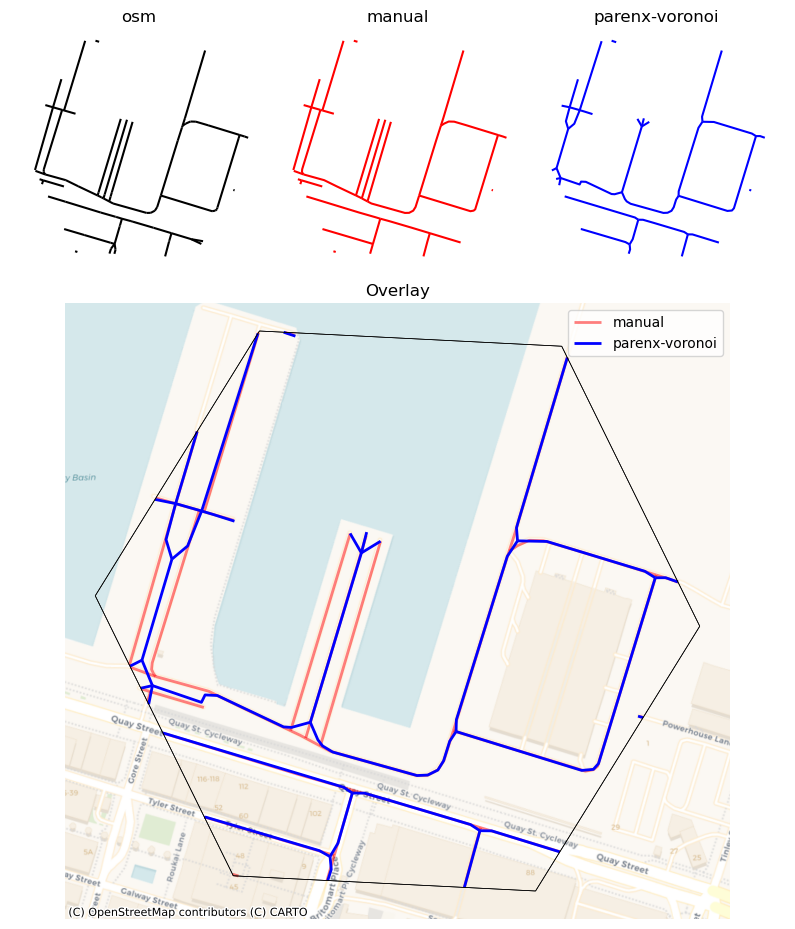

In [16]:
grid_id = 84  # which cell to plot -- index location
viz.h3_hex.plot_cell(grid_id, grid, orig, "osm", base, base_name, comp, comp_name)

(<Figure size 1000x1400 with 4 Axes>,
 {'orig': <Axes: label='orig', title={'center': 'osm'}>,
  'base': <Axes: label='base', title={'center': 'manual'}>,
  'comp': <Axes: label='comp', title={'center': 'parenx-voronoi'}>,
  'agg': <Axes: label='agg', title={'center': 'Overlay'}>})

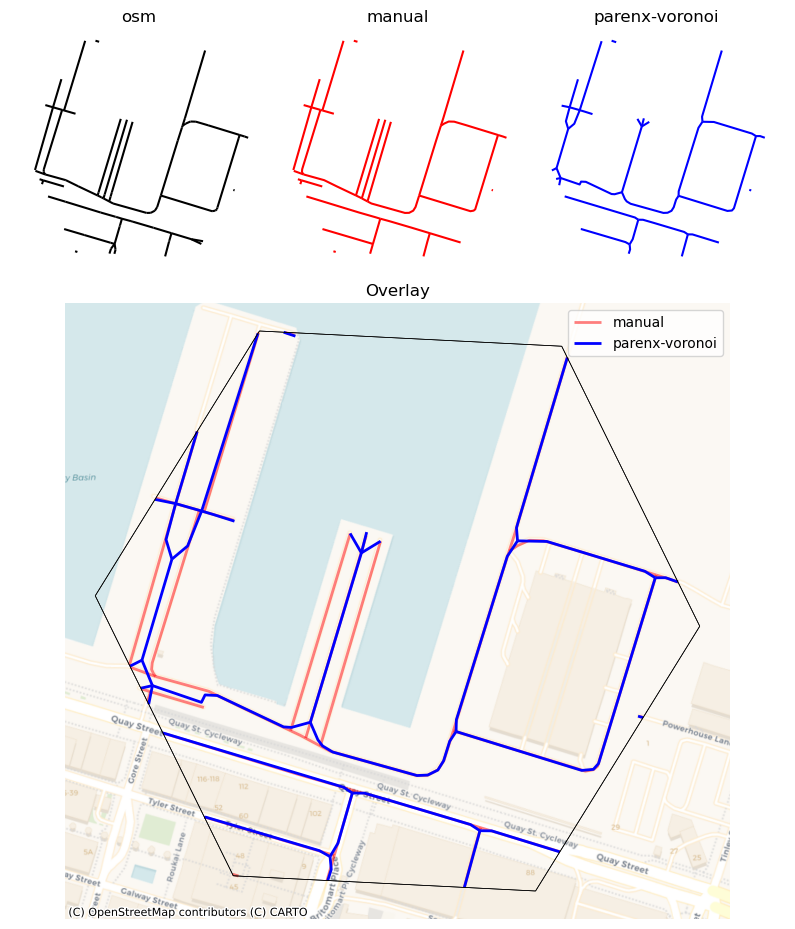

In [17]:
grid_id = "89bb5000563ffff"  # which cell to plot -- H3 ID
viz.h3_hex.plot_cell(grid_id, grid, orig, "osm", base, base_name, comp, comp_name)

## Generate single cell plots 
... for top 10 instances where total geom length in comp is higher than in manual

In [18]:
usecase_path = pathlib.Path("..", "usecases", str(fua))

In [19]:
subfolder = usecase_path / "totallength"
subfolder.mkdir(parents=True, exist_ok=True)

var = "edge_length_ratio"
cells_to_plot = grid[grid[var] > 1].sort_values(by=var, ascending=False)["hex_id"][:10]

for cell in cells_to_plot:
    ratio = np.round(grid.loc[(grid["hex_id"] == cell), var].squeeze(), 3)
    fig, _ = viz.h3_hex.plot_cell(
        cell, grid, orig, "osm", base, base_name, comp, comp_name
    )
    plt.suptitle(
        f"Total length ratio ({comp_name}/{base_name}): {ratio}", fontsize=15, y=0.85
    )
    plt.tight_layout()
    fig.savefig(subfolder / f"{cell}.png", dpi=300)
    plt.close()

## Generate single cell plots 
... for top 10 instances where average node degree in comp is lower than in manual

In [20]:
subfolder = usecase_path / "averagedegree"
subfolder.mkdir(parents=True, exist_ok=True)

var = "avg_degree_ratio"
cells_to_plot = grid[(grid[var] < 1) & (grid[var] > 0)].sort_values(
    by=var, ascending=True
)["hex_id"][:10]

for cell in cells_to_plot:
    ratio = np.round(grid.loc[(grid["hex_id"] == cell), var].squeeze(), 3)
    fig, _ = viz.h3_hex.plot_cell(
        cell, grid, orig, "osm", base, base_name, comp, comp_name
    )
    plt.suptitle(
        f"Average node degree ratio ({comp_name}/{base_name}): {ratio}",
        fontsize=15,
        y=0.8,
    )
    fig.savefig(subfolder / f"{cell}.png", dpi=300)
    plt.close()